# CW Attack Example

TJ Kim <br />
1.28.21

### Summary: 
Implement CW attack on toy network example given in the readme of the github. <br />
https://github.com/tj-kim/pytorch-cw2?organization=tj-kim&organization=tj-kim

A dummy network is made using CIFAR example. <br />
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

### Build Dummy Pytorch Network

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

Download a few classes from the dataset.

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Show a few images from the dataset.

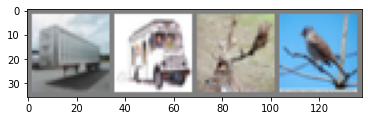

truck truck  deer  bird


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Define a NN.

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Define loss and optimizer

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Train the Network

In [7]:
net = Net()
train_flag = False

if train_flag:
    for epoch in range(2):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')
else:
    net.load_state_dict(torch.load(PATH))

[1,  2000] loss: 2.224
[1,  4000] loss: 1.879
[1,  6000] loss: 1.676
[1,  8000] loss: 1.588
[1, 10000] loss: 1.511
[1, 12000] loss: 1.445
[2,  2000] loss: 1.388
[2,  4000] loss: 1.358
[2,  6000] loss: 1.341
[2,  8000] loss: 1.298
[2, 10000] loss: 1.295
[2, 12000] loss: 1.274
Finished Training


Save Existing Network.

In [8]:
if train_flag:
    PATH = './cifar_net.pth'
    torch.save(net.state_dict(), PATH)

Test Acc.

In [10]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 52 %


### C&W Attack

Perform attack on toy network.

In [1]:
import torch
import cw

inputs_box = (min((0 - m) / s for m, s in zip(mean, std)),
              max((1 - m) / s for m, s in zip(mean, std)))
# an untargeted adversary
adversary = cw.L2Adversary(targeted=False,
                           confidence=0.0,
                           search_steps=10,
                           box=inputs_box,
                           optimizer_lr=5e-4)

inputs, targets = next(iter(dataloader))
adversarial_examples = adversary(net, inputs, targets, to_numpy=False)
assert isinstance(adversarial_examples, torch.FloatTensor)
assert adversarial_examples.size() == inputs.size()

# a targeted adversary
adversary = cw.L2Adversary(targeted=True,
                           confidence=0.0,
                           search_steps=10,
                           box=inputs_box,
                           optimizer_lr=5e-4)

inputs, _ = next(iter(dataloader))
# a batch of any attack targets
attack_targets = torch.ones(inputs.size(0)) * 3
adversarial_examples = adversary(net, inputs, attack_targets, to_numpy=False)
assert isinstance(adversarial_examples, torch.FloatTensor)
assert adversarial_examples.size() == inputs.size()

NameError: name 'mean' is not defined